In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, sigmoid_kernel


In [18]:
MOVIES_CSV = "../data/raw/tmdb_5000_movies.csv"
CREDITS_CSV = "../data/raw/tmdb_5000_credits.csv"

movies = pd.read_csv(MOVIES_CSV)
credits = pd.read_csv(CREDITS_CSV).rename(columns={"movie_id": "id"})

df = movies.merge(credits, on="id", how="inner").drop_duplicates()
print(f"Initial dataset shape: {df.shape}")

Initial dataset shape: (4803, 23)


In [19]:
df = df.drop(columns=["homepage", "status", "title_x", "title_y", "production_countries"])
df = df.dropna(subset=["overview"])
df = df.reset_index(drop=True)
print(f"After cleaning: {df.shape}")

After cleaning: (4800, 18)


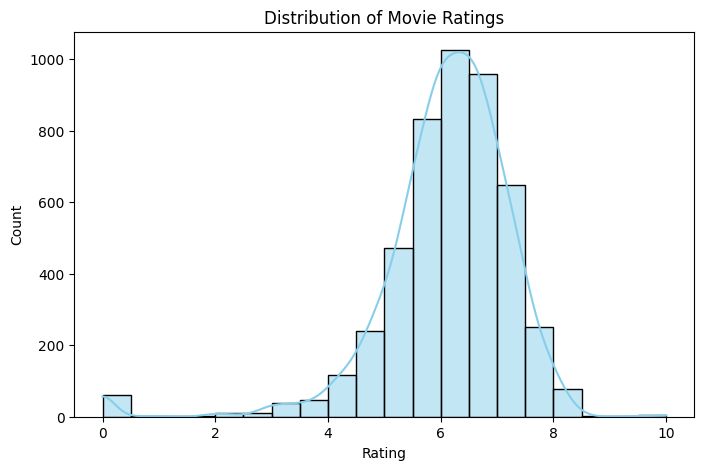

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df["vote_average"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

C:\Users\ERICA\AppData\Local\Temp\ipykernel_33424\2513343736.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=pd.Series(all_genres), order=pd.Series(all_genres).value_counts().index[:15], palette="viridis")


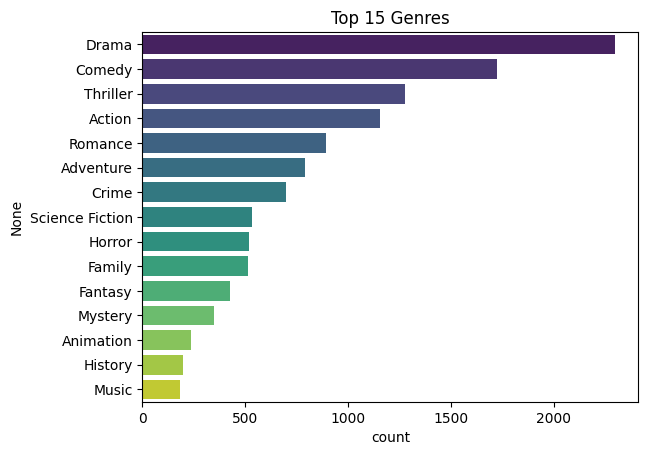

In [21]:
from ast import literal_eval
df["genres"] = df["genres"].apply(lambda x: [d["name"] for d in literal_eval(x)] if pd.notna(x) else [])
all_genres = [g for sublist in df["genres"] for g in sublist]
sns.countplot(y=pd.Series(all_genres), order=pd.Series(all_genres).value_counts().index[:15], palette="viridis")
plt.title("Top 15 Genres")
plt.show()

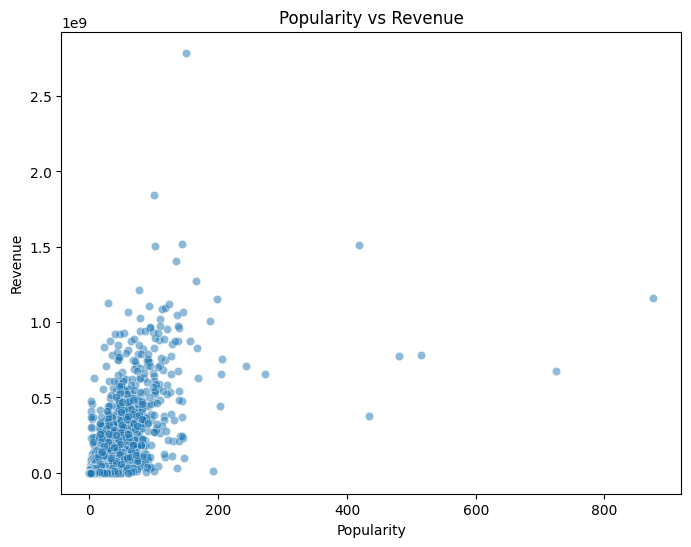

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="popularity", y="revenue", alpha=0.5)
plt.title("Popularity vs Revenue")
plt.xlabel("Popularity")
plt.ylabel("Revenue")
plt.show()

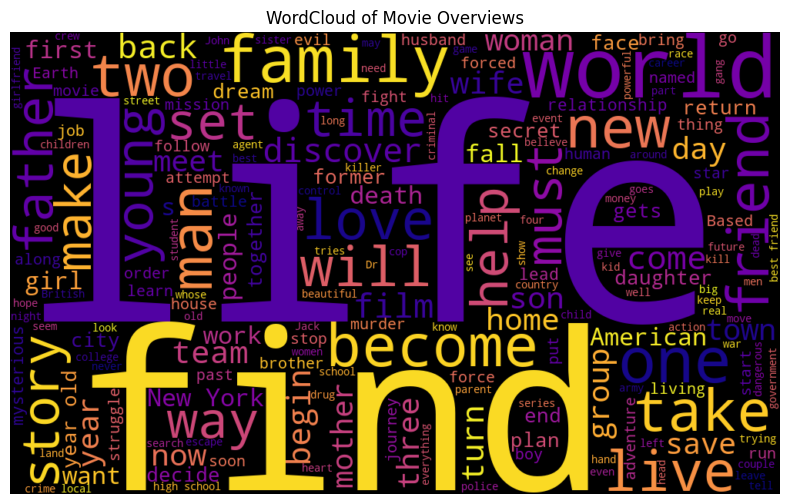

In [23]:
text = " ".join(df["overview"].astype(str).tolist())
wc = WordCloud(width=1000, height=600, background_color="black", colormap="plasma").generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Movie Overviews")
plt.show()

In [24]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(df["overview"])
sim_tfidf = cosine_similarity(tfidf_matrix)

count = CountVectorizer(stop_words="english")
count_matrix = count.fit_transform(df["overview"])
sim_count = cosine_similarity(count_matrix)

sim_sigmoid = sigmoid_kernel(tfidf_matrix)

indices = pd.Series(df.index, index=df["original_title"]).drop_duplicates()

def recommend_with_scores(title, sim_matrix, df, top_n=10):
    idx = indices[title]
    sim_scores = sorted(list(enumerate(sim_matrix[idx])), key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    return list(zip(df["original_title"].iloc[movie_indices], scores))

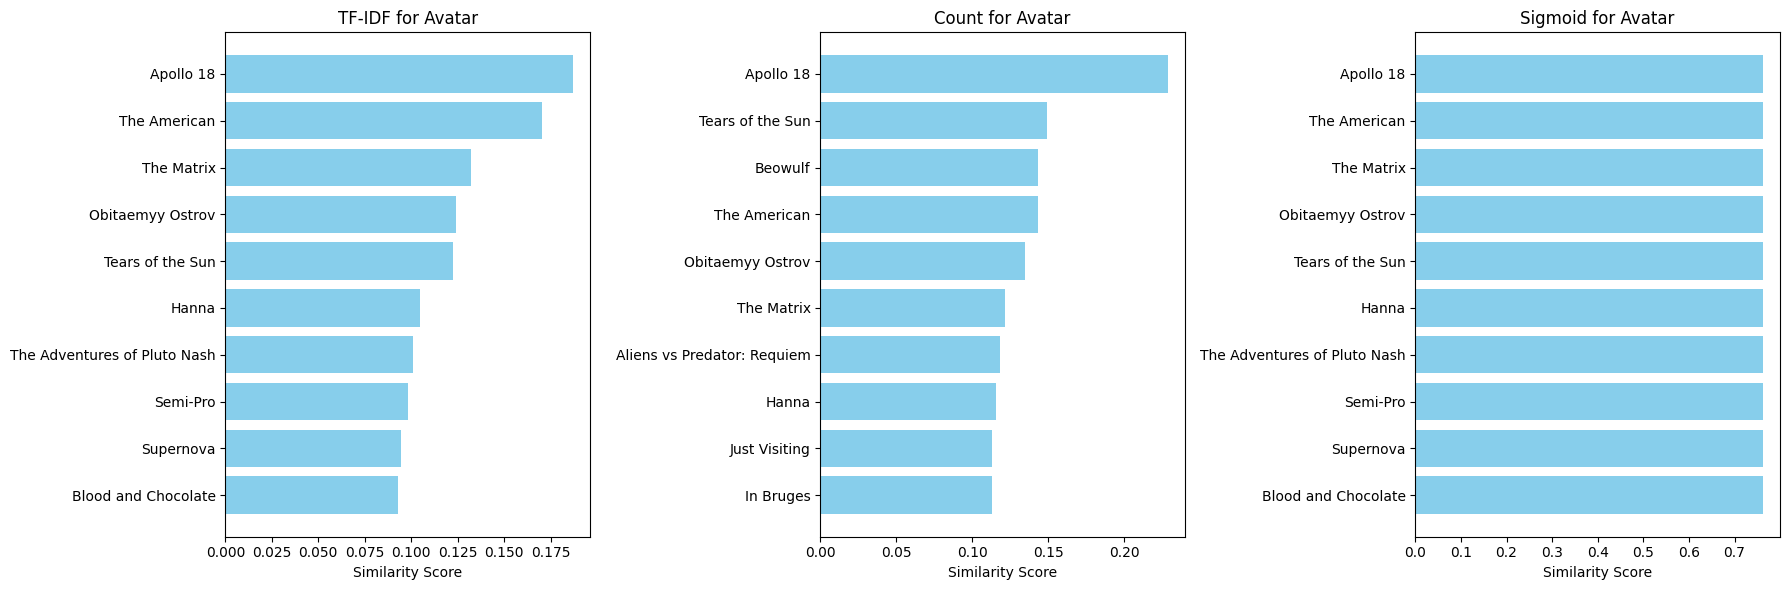

In [25]:
def plot_recommendations(movie, sims, labels, df, top_n=10):
    fig, axes = plt.subplots(1, len(sims), figsize=(18,6))
    for ax, sim, label in zip(axes, sims, labels):
        recs = recommend_with_scores(movie, sim, df, top_n)
        titles, scores = zip(*recs)
        ax.barh(titles[::-1], scores[::-1], color="skyblue")
        ax.set_title(f"{label} for {movie}")
        ax.set_xlabel("Similarity Score")
    plt.tight_layout()
    plt.show()

plot_recommendations("Avatar", [sim_tfidf, sim_count, sim_sigmoid], ["TF-IDF", "Count", "Sigmoid"], df)

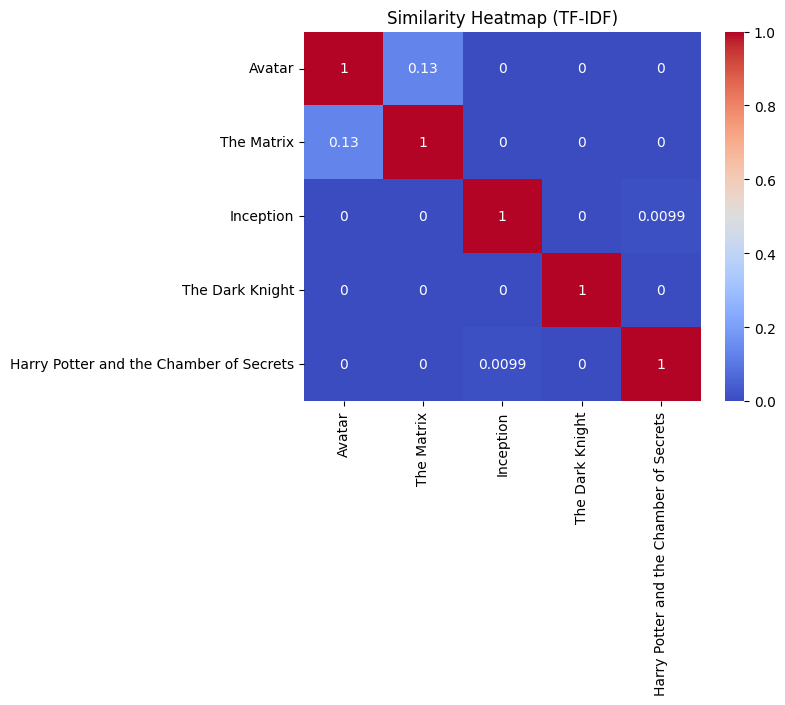

In [26]:
sample_movies = ["Avatar", "The Matrix", "Inception", "The Dark Knight", "Harry Potter and the Chamber of Secrets"]
sample_indices = [indices[m] for m in sample_movies]

sim_matrix_sample = sim_tfidf[np.ix_(sample_indices, sample_indices)]
sns.heatmap(sim_matrix_sample, xticklabels=sample_movies, yticklabels=sample_movies, annot=True, cmap="coolwarm")
plt.title("Similarity Heatmap (TF-IDF)")
plt.show()

In [29]:
# DataFrame check
assert df is not None and not df.empty, "DataFrame is empty!"
assert "original_title" in df.columns and "overview" in df.columns, "Missing key columns!"

# Similarity matrices check
assert sim_tfidf.shape[0] == len(df), "TF-IDF matrix size mismatch!"
assert sim_count.shape[0] == len(df), "Count matrix size mismatch!"
assert sim_sigmoid.shape[0] == len(df), "Sigmoid matrix size mismatch!"

# Recommendation check
out = recommend_with_scores("Avatar", sim_tfidf, df, top_n=5)
assert len(out) == 5, "Recommendation did not return 5 movies!"

print("Notebook pipeline works correctly!")
print("Top 5 recommendations for Avatar:")
for title, score in out:
    print(f" - {title} ({score:.3f})")


Notebook pipeline works correctly!
Top 5 recommendations for Avatar:
 - Apollo 18 (0.187)
 - The American (0.170)
 - The Matrix (0.132)
 - Obitaemyy Ostrov (0.124)
 - Tears of the Sun (0.122)
